In [1]:
import os
import gc
import numpy as np
import pandas as pd
from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt
import pickle
from shutil import copyfile
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import cv2

from keras.utils import Sequence
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/trainimage"))

# Any results you write to the current directory are saved as output.

['train', 'train.csv']


In [3]:
data_train = pd.read_csv('../input/trainimage/train.csv')
data_train.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


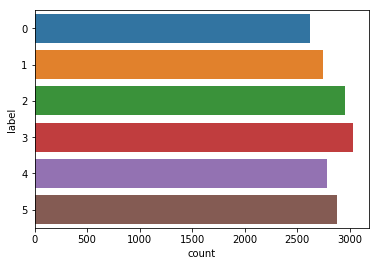

In [4]:
sns.countplot(y='label', data=data_train)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data_train['image_name'].values, data_train['label'].values, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

(11923,) (5111,)


In [6]:
print(list(zip(X_train[:5], y_train[:5])))
print(list(zip(X_test[:5], y_test[:5])))

[('1775.jpg', 4), ('11351.jpg', 4), ('22654.jpg', 5), ('9530.jpg', 5), ('23547.jpg', 5)]
[('16451.jpg', 2), ('9117.jpg', 0), ('14885.jpg', 0), ('3067.jpg', 0), ('5323.jpg', 1)]


In [7]:
%%time

#Building the Folder Structure
DATA_DIR = '../input/trainimage/train'

if not os.path.isdir('data'):
        os.mkdir('data')

# Create the Training data
if not os.path.isdir(os.path.join('data', 'train')):
        os.mkdir(os.path.join('data', 'train'))
root = os.path.join('data', 'train')
for i in tqdm(range(len(X_train))):
    label_dir = os.path.join(root, str(y_train[i]))
    if not os.path.isdir(label_dir):
        os.mkdir(label_dir)
    src = os.path.join(DATA_DIR, X_train[i])
    dst = os.path.join(label_dir, X_train[i])
    copyfile(src, dst)

# Create the Test data
if not os.path.isdir(os.path.join('data', 'test')):
        os.mkdir(os.path.join('data', 'test'))
root = os.path.join('data', 'test')
for i in tqdm(range(len(X_test))):
    label_dir = os.path.join(root, str(y_test[i]))
    if not os.path.isdir(label_dir):
        os.mkdir(label_dir)
    src = os.path.join(DATA_DIR, X_test[i])
    dst = os.path.join(label_dir, X_test[i])
    copyfile(src, dst)


CPU times: user 4.42 s, sys: 4.75 s, total: 9.17 s
Wall time: 1min 1s


In [8]:
list(os.walk('data'))[0]

('data', ['train', 'test'], [])

# Transfer Learning using ResNet-152

In [9]:
# transforms.CenterCrop(224),
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomRotation(0.3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
train_set = datasets.ImageFolder("data/train", transform = transformations)
test_set = datasets.ImageFolder("data/test", transform = transformations)

In [11]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size =32, shuffle=True)

In [12]:
%%time
model = models.resnet152(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.torch/models/resnet152-b121ed2d.pth
241530880it [00:03, 79942155.59it/s]


CPU times: user 4.02 s, sys: 1.36 s, total: 5.37 s
Wall time: 9.26 s


In [13]:
classifier_input = model.fc.in_features; num_labels = 6;
classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(512, 128),
                           nn.ReLU(),
                           nn.Linear(128, num_labels),
                           nn.LogSoftmax(dim=1))

model.fc = classifier
# model.classifier = classifier

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())
# optimizer = optim.Adam(model.classifier.parameters())

In [16]:
epochs = 10
tr_list = []; val_list = []; acc = [];
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Print the progress of our training
        counter += 1
        if counter % 350 == 0:
            print(counter, "/", len(train_loader))
    
    print()
    # Evaluating the model
    model.eval()
    counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Print the progress of our evaluation
            counter += 1
            if counter % 150 == 0:
                print(counter, "/", len(test_loader))
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(test_loader.dataset)
    # Print out the information
    print('Accuracy: ', accuracy/len(test_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    tr_list.append(train_loss)
    val_list.append(valid_loss)
    acc.append(accuracy/len(test_loader))

350 / 373

150 / 160
Accuracy:  0.8970363449305296
Epoch: 0 	Training Loss: 0.563650 	Validation Loss: 0.296186
350 / 373

150 / 160
Accuracy:  0.897265625
Epoch: 1 	Training Loss: 0.388754 	Validation Loss: 0.269382
350 / 373

150 / 160
Accuracy:  0.9077021058648824
Epoch: 2 	Training Loss: 0.362829 	Validation Loss: 0.257260
350 / 373

150 / 160
Accuracy:  0.9092646058648824
Epoch: 3 	Training Loss: 0.354674 	Validation Loss: 0.241756
350 / 373

150 / 160
Accuracy:  0.9121178667992353
Epoch: 4 	Training Loss: 0.334226 	Validation Loss: 0.240752
350 / 373

150 / 160
Accuracy:  0.9092985734343528
Epoch: 5 	Training Loss: 0.340515 	Validation Loss: 0.240761
350 / 373

150 / 160
Accuracy:  0.9077021058648824
Epoch: 6 	Training Loss: 0.339051 	Validation Loss: 0.276314
350 / 373

150 / 160
Accuracy:  0.9057829484343529
Epoch: 7 	Training Loss: 0.324272 	Validation Loss: 0.262964
350 / 373

150 / 160
Accuracy:  0.9099269699305296
Epoch: 8 	Training Loss: 0.312983 	Validation Loss: 0.250095

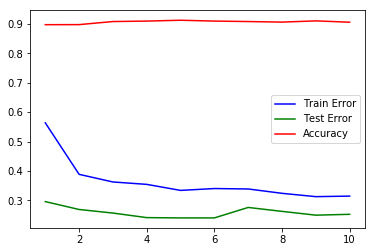

In [17]:
plt.plot(range(1,11), tr_list, 'b-', label='Train Error')
plt.plot(range(1,11), val_list, 'g-', label='Test Error')
plt.plot(range(1,11), acc, 'r-', label='Accuracy')
plt.legend(loc='best')
plt.show()

In [18]:
print("Training Error:", max(tr_list), min(tr_list))
print("Test Error:", max(val_list), min(val_list))
print("Accuracy:", max(acc), min(acc))

Training Error: 0.5636497712756207 0.31298276403351616
Test Error: 0.2961864807710235 0.24075227042299688
Accuracy: 0.9121178667992353 0.8970363449305296


In [19]:
del model; gc.collect()

2678

# Shallow CNN from Scratch

In [20]:
# DATA_DIR = '../input/trainimage/train'

# X_train = [f'{DATA_DIR}/{x}' for x in tqdm(X_train)]
# X_test = [f'{DATA_DIR}/{x}' for x in tqdm(X_test)]

In [21]:
# class Data_Generator(Sequence):

#     def __init__(self, image_filenames, labels, batch_size):
#         self.image_filenames, self.labels = image_filenames, labels
#         self.batch_size = batch_size

#     def __len__(self):
#         return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

#     def __getitem__(self, idx):
#         batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

#         return np.array([resize(plt.imread(file_name), (img_size, img_size))/255.0 for file_name in batch_x]), np.array(batch_y)

In [22]:
# img_size = 230; batch_size = 16; epochs = 10; num_classes = 6;

# train_generator = Data_Generator(X_train, y_train, batch_size)
# test_generator = Data_Generator(X_test, y_test, batch_size)

In [23]:
# x_train = np.empty((len(X_train), img_size, img_size, 3), dtype='float32')
# x_test = np.empty((len(X_test), img_size, img_size, 3), dtype='float32')

# for i in tqdm(range(1, len(X_train))):
#     img = plt.imread(f'{DATA_DIR}/{X_train[i]}')
#     x_train[i] = resize(img, (img_size, img_size), anti_aliasing=True)
    
# for i in tqdm(range(1, len(X_test))):
#     img = plt.imread(f'{DATA_DIR}/{X_test[i]}')
#     x_test[i] = resize(img, (img_size, img_size), anti_aliasing=True)

# x_train /= 255
# x_test /= 255

# print(x_train.shape, x_test.shape)

In [28]:
img_size = 230; batch_size = 32; epochs = 15; num_classes = 6;

train_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255,
    shear_range=0.2,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=True,
    channel_shift_range=0.2,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='sparse')

Found 11923 images belonging to 6 classes.
Found 5111 images belonging to 6 classes.


In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GaussianNoise, BatchNormalization
# from keras.applications import InceptionV3, VGG16, ResNet50

# base_net = VGG16(include_top=False,
#                  input_shape = (img_size,img_size,3),
#                  weights = 'imagenet')
# base_net.trainable = False

model = Sequential()
# model.add(base_net)
# model.add(GaussianNoise(0.3))
model.add(Conv2D(64, kernel_size=(7, 7), activation='relu', padding='same', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (7, 7), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# model.add(Conv2D(128, (7, 7), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (7, 7), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# model.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(2048, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
# model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
# print(model.summary())

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=(len(X_train) // batch_size),
                    epochs=epochs,
                    verbose=1,
                    validation_data=test_generator,
                    validation_steps=(len(X_test) // batch_size),
#                     use_multiprocessing=True,
#                     workers=16,
                    max_queue_size=32)
#                     shuffle=True)

# history = model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_test, y_test))

# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

Epoch 1/10
372/372 [==============================] - 235s 632ms/step - loss: 59.7983 - acc: 0.4078 - val_loss: 7.7348 - val_acc: 0.1822
Epoch 2/10
372/372 [==============================] - 221s 594ms/step - loss: 3.9210 - acc: 0.4334 - val_loss: 2.9824 - val_acc: 0.2938
Epoch 3/10
372/372 [==============================] - 220s 591ms/step - loss: 2.3425 - acc: 0.4351 - val_loss: 3.5775 - val_acc: 0.1843
Epoch 4/10
372/372 [==============================] - 221s 594ms/step - loss: 2.1586 - acc: 0.4275 - val_loss: 3.9415 - val_acc: 0.1611
Epoch 5/10
372/372 [==============================] - 221s 594ms/step - loss: 2.1399 - acc: 0.4233 - val_loss: 4.9955 - val_acc: 0.1719
Epoch 6/10
372/372 [==============================] - 220s 590ms/step - loss: 2.0627 - acc: 0.4224 - val_loss: 2.6102 - val_acc: 0.3166
Epoch 7/10
372/372 [==============================] - 218s 586ms/step - loss: 1.9928 - acc: 0.4253 - val_loss: 3.4611 - val_acc: 0.1729
Epoch 8/10
372/372 [===========================

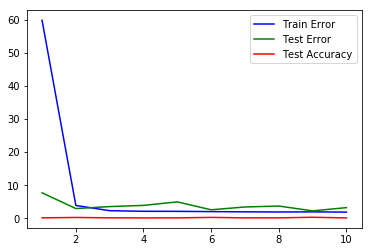

In [30]:
plt.plot(range(1,epochs+1), history.history['loss'], 'b-', label='Train Error')
plt.plot(range(1,epochs+1), history.history['val_loss'], 'g-', label='Test Error')
plt.plot(range(1,epochs+1), history.history['val_acc'], 'r-', label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [31]:
print("Training Error:", max(history.history['loss']), min(history.history['loss']))
print("Test Error:", max(history.history['val_loss']), min(history.history['val_loss']))
print("Test Accuracy:", max(history.history['val_acc']), min(history.history['val_acc']))

Training Error: 59.79832463751557 1.9138480919923848
Test Error: 7.734771314656959 2.2863769269782885
Test Accuracy: 0.3591258121501463 0.15888954517432474


In [ ]:
del model; gc.collect()

# Conclusion :-
- The pretrained model is performing much better than the models from scratch.
- Model with Data Augmentation is performing better than the Model without Augmentation.